Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Export started from Earth Engine. Wait for download from Google Drive.
Image and mask saved for training.
Epoch 1/50: Loss = 0.696379
Epoch 2/50: Loss = 0.694649
Epoch 3/50: Loss = 0.693021
Epoch 4/50: Loss = 0.691493
Epoch 5/50: Loss = 0.690012
Epoch 6/50: Loss = 0.688449
Epoch 7/50: Loss = 0.686769
Epoch 8/50: Loss = 0.684922
Epoch 9/50: Loss = 0.682853
Epoch 10/50: Loss = 0.680542
Epoch 11/50: Loss = 0.677989
Epoch 12/50: Loss = 0.675124
Epoch 13/50: Loss = 0.671850
Epoch 14/50: Loss = 0.668090
Epoch 15/50: Loss = 0.663748
Epoch 16/50: Loss = 0.658712
Epoch 17/50: Loss = 0.652829
Epoch 18/50: Loss = 0.645843
Epoch 19/50: Loss = 0.637506
Epoch 20/50: Loss = 0.627534
Epoch 21/50: Loss = 0.615594
Epoch 22/50: Loss = 0.601423
Epoch 23/50: Loss = 0.585113
Epoch 24/50: Loss = 0.567577
Epoch 25/50: Loss = 0.551547
Epoch 26/50: Loss = 0.543682
Epoch 27/50: Loss = 

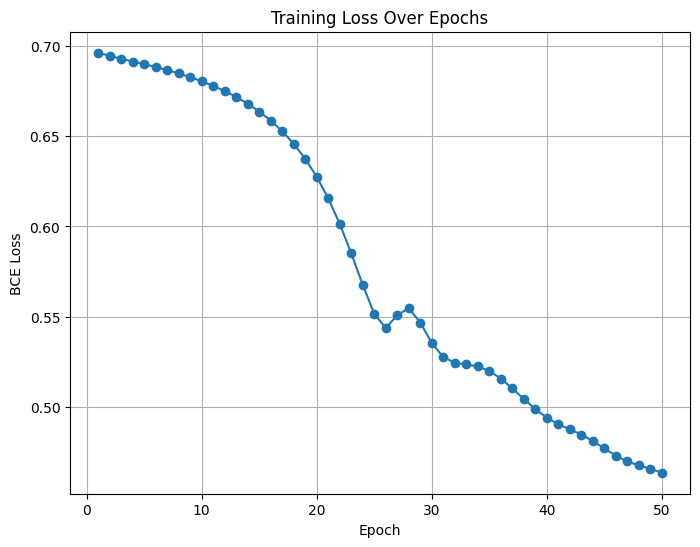

Saved predicted whole mask in 'outputs/predicted_whole_image.png'.
IoU: 0.9039, Precision: 0.9093, Recall: 0.9934


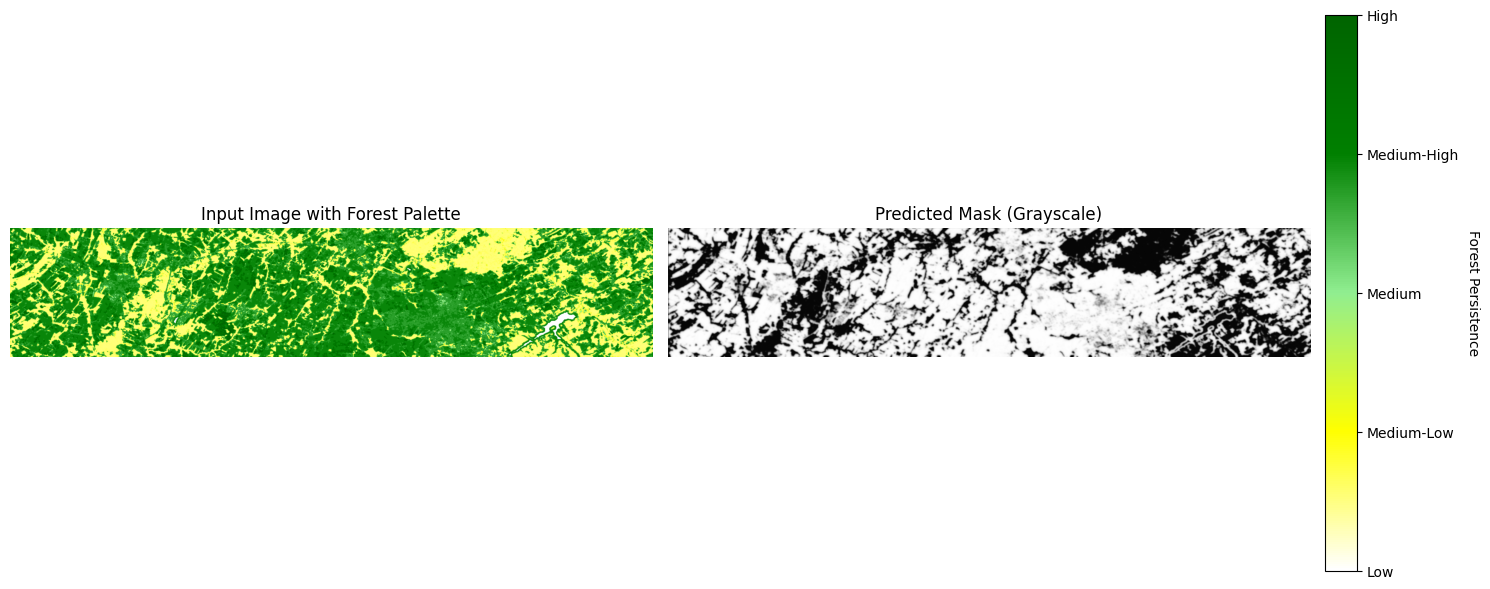

In [ ]:
# ==========================================
# Step 0: Install required libraries
# pip install earthengine-api geemap torch torchvision opencv-python matplotlib Pillow
# ==========================================
from google.colab import drive
drive.mount('/content/drive')
# Step 1: Google Earth Engine setup and export
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='erudite-imprint-458001-e5')

roi = ee.Geometry.BBox(-60.0, -10.0, -59.5, -9.5)
gfc = ee.Image('UMD/hansen/global_forest_change_2020_v1_8')
loss = gfc.select('loss')

task = ee.batch.Export.image.toDrive(
    image=loss.clip(roi),
    description='forest_loss_amazon',
    folder='EarthEngineExports',
    fileNamePrefix='forest_loss_amazon',
    region=roi,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e9
)
task.start()
print("Export started from Earth Engine. Wait for download from Google Drive.")

# ==========================================
# Step 2: Convert .tif to .png
# ==========================================
from PIL import Image
import os
# add the file path of the datset that is taken we have downloaded inidividual
#dataset ie image from the satelllite imaging and into the drive directly and added its path here
tif_path = "/content/drive/MyDrive/mask/persistent_forest_colored_washington.tif"
image = Image.open(tif_path)

os.makedirs("data/images", exist_ok=True)
os.makedirs("data/masks", exist_ok=True)

image.convert("RGB").save("data/images/forest_persistence_raw.png")
image.convert("L").save("data/masks/forest_persistence_raw.png")

print("Image and mask saved for training.")

# ==========================================
# Step 3: Define U-Net Model
# ==========================================
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        return torch.sigmoid(self.final(dec1))

# ==========================================
# Step 4: Dataset Loader
# ==========================================
from torch.utils.data import Dataset, DataLoader
import cv2

class ForestDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

# ==========================================
# Helper functions: Padding and Cropping
# ==========================================
import torch.nn.functional as F

def pad_to_multiple(x, multiple=32):
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    x_padded = F.pad(x, (0, pad_w, 0, pad_h), mode='reflect')
    return x_padded, h, w

def unpad(x, h, w):
    return x[:, :, :h, :w]

# ==========================================
# Step 5: Training Loop
# ==========================================
import torch.optim as optim
import matplotlib.pyplot as plt

train_dataset = ForestDataset("data/images", "data/masks")

if len(train_dataset) == 0:
    print("Add image and mask files in 'data/images' and 'data/masks' before training.")
else:
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    model = UNet()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 50  # Change to 50 epochs
    loss_history = []  # <-- Track losses here!

    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0
        for img, mask in train_loader:
            img, orig_h, orig_w = pad_to_multiple(img)
            mask, _, _ = pad_to_multiple(mask)

            pred = model(img)
            loss = criterion(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        avg_loss = loss_sum / len(train_loader)
        loss_history.append(avg_loss)  # <-- Save average loss per epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.6f}")

    # ==========================================
    # After training: Plot the loss curve
    # ==========================================
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.grid(True)
    plt.savefig("outputs/loss_curve.png")  # Save plot
    plt.show()


# ==========================================
# Step 6: Evaluation + Save Whole Image Output
# ==========================================
os.makedirs("outputs", exist_ok=True)
model.eval()

input_path = "data/images/forest_persistence_raw.png"
image = cv2.imread(input_path)

image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
image_padded, orig_h, orig_w = pad_to_multiple(image_tensor)

with torch.no_grad():
    pred_padded = model(image_padded)

prediction = unpad(pred_padded, orig_h, orig_w)

pred_mask = prediction.squeeze().numpy() * 255
cv2.imwrite("outputs/predicted_whole_image.png", pred_mask.astype('uint8'))

print("Saved predicted whole mask in 'outputs/predicted_whole_image.png'.")
# ==========================================
#  Calculate IoU, Precision, Recall
# (Fixed Metrics Calculation)

def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred_binary = (pred_mask >= threshold).astype(np.uint8)
    true_binary = (true_mask >= threshold).astype(np.uint8)

    intersection = (pred_binary & true_binary).sum()
    union = (pred_binary | true_binary).sum()
    iou = intersection / (union + 1e-6)

    tp = (pred_binary * true_binary).sum()
    fp = (pred_binary * (1 - true_binary)).sum()
    fn = ((1 - pred_binary) * true_binary).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return iou, precision, recall

# Load ground truth mask (normalize to [0,1])
true_mask_path = "data/masks/forest_persistence_raw.png"
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Load prediction and normalize (IMPORTANT)
pred_mask = cv2.imread("outputs/predicted_whole_image.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Resize if necessary
pred_resized = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

# Calculate metrics
iou, precision, recall = calculate_metrics(pred_resized, true_mask)

print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



# ==========================================
# Step 7: Visualization
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colorbar as colorbar

# Load input
img_np = image_tensor.squeeze().permute(1, 2, 0).numpy()
pred_np = prediction.squeeze().numpy()

# -- Prepare custom colormap for Input Image --
colors = [
    (1.0, 1.0, 1.0),    # White
    (1.0, 1.0, 0.0),    # Yellow
    (0.5647, 0.9333, 0.5647),  # Light Green
    (0.0, 0.5, 0.0),    # Green
    (0.0, 0.3922, 0.0)  # Dark Green
]
forest_cmap = LinearSegmentedColormap.from_list("forest_palette", colors, N=256)

# Convert input image to grayscale for applying palette
img_gray = img_np.mean(axis=2)

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# --- Input image (apply forest colormap) ---
im0 = axs[0].imshow(img_gray, cmap=forest_cmap, vmin=0, vmax=1)
axs[0].set_title("Input Image with Forest Palette")
axs[0].axis("off")

# --- Predicted mask (grayscale, no change) ---
axs[1].imshow(pred_np, cmap='gray')
axs[1].set_title("Predicted Mask (Grayscale)")
axs[1].axis("off")

# --- Colorbar ---
cbar = plt.colorbar(im0, cax=axs[2])
cbar.set_label('Forest Persistence', rotation=270, labelpad=15)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Export started from Earth Engine. Wait for download from Google Drive.
Image and mask saved for training.
Epoch 1/50: Loss = 0.687340
Epoch 2/50: Loss = 0.685621
Epoch 3/50: Loss = 0.683997
Epoch 4/50: Loss = 0.682374
Epoch 5/50: Loss = 0.680750
Epoch 6/50: Loss = 0.679396
Epoch 7/50: Loss = 0.678054
Epoch 8/50: Loss = 0.676466
Epoch 9/50: Loss = 0.674653
Epoch 10/50: Loss = 0.672588
Epoch 11/50: Loss = 0.670273
Epoch 12/50: Loss = 0.667761
Epoch 13/50: Loss = 0.665002
Epoch 14/50: Loss = 0.661943
Epoch 15/50: Loss = 0.658532
Epoch 16/50: Loss = 0.654800
Epoch 17/50: Loss = 0.650647
Epoch 18/50: Loss = 0.645998
Epoch 19/50: Loss = 0.640890
Epoch 20/50: Loss = 0.635177
Epoch 21/50: Loss = 0.628704
Epoch 22/50: Loss = 0.621315
Epoch 23/50: Loss = 0.612933
Epoch 24/50: Loss = 0.603428
Epoch 25/50: Loss = 0.592635
Epoch 26/50: Loss = 0.580404
Epoch 27/50: Loss = 

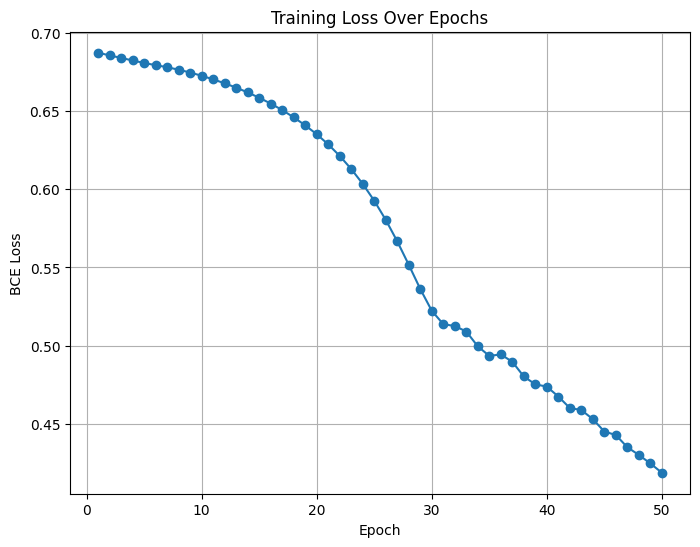

Saved predicted whole mask in 'outputs/predicted_whole_image.png'.
IoU: 0.9481, Precision: 0.9905, Recall: 0.9568


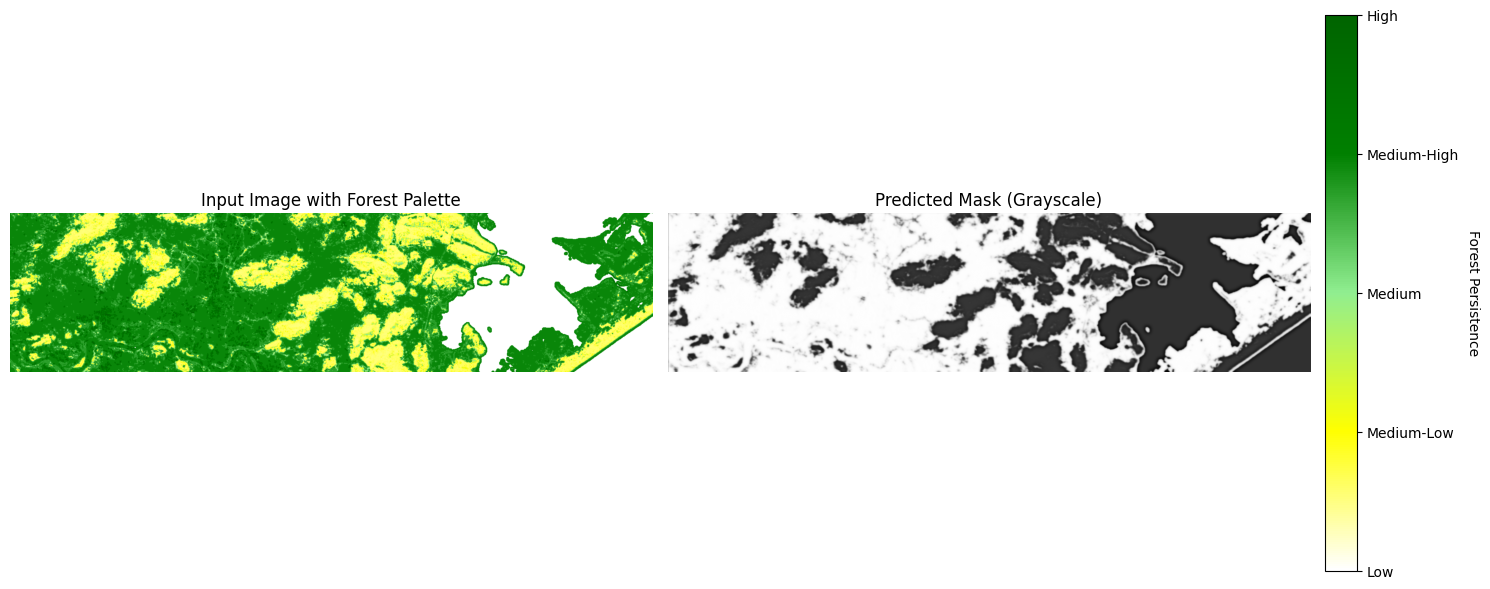

In [ ]:
# ==========================================
# Step 0: Install required libraries
# pip install earthengine-api geemap torch torchvision opencv-python matplotlib Pillow
# ==========================================
from google.colab import drive
drive.mount('/content/drive')
# Step 1: Google Earth Engine setup and export
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='erudite-imprint-458001-e5')

roi = ee.Geometry.BBox(-60.0, -10.0, -59.5, -9.5)
gfc = ee.Image('UMD/hansen/global_forest_change_2020_v1_8')
loss = gfc.select('loss')

task = ee.batch.Export.image.toDrive(
    image=loss.clip(roi),
    description='forest_loss_amazon',
    folder='EarthEngineExports',
    fileNamePrefix='forest_loss_amazon',
    region=roi,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e9
)
task.start()
print("Export started from Earth Engine. Wait for download from Google Drive.")

# ==========================================
# Step 2: Convert .tif to .png
# ==========================================
from PIL import Image
import os

tif_path = "/content/drive/MyDrive/mask/persistent_forest_colored_india.tif"
image = Image.open(tif_path)

os.makedirs("data/images", exist_ok=True)
os.makedirs("data/masks", exist_ok=True)

image.convert("RGB").save("data/images/forest_persistence_raw.png")
image.convert("L").save("data/masks/forest_persistence_raw.png")

print("Image and mask saved for training.")

# ==========================================
# Step 3: Define U-Net Model
# ==========================================
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        return torch.sigmoid(self.final(dec1))

# ==========================================
# Step 4: Dataset Loader
# ==========================================
from torch.utils.data import Dataset, DataLoader
import cv2

class ForestDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

# ==========================================
# Helper functions: Padding and Cropping
# ==========================================
import torch.nn.functional as F

def pad_to_multiple(x, multiple=32):
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    x_padded = F.pad(x, (0, pad_w, 0, pad_h), mode='reflect')
    return x_padded, h, w

def unpad(x, h, w):
    return x[:, :, :h, :w]

# ==========================================
# Step 5: Training Loop
# ==========================================
# ==========================================
# Step 5: Training Loop (Updated with Loss Plot)
# ==========================================
import torch.optim as optim
import matplotlib.pyplot as plt

train_dataset = ForestDataset("data/images", "data/masks")

if len(train_dataset) == 0:
    print("Add image and mask files in 'data/images' and 'data/masks' before training.")
else:
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    model = UNet()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 50  # Change to 50 epochs
    loss_history = []  # <-- Track losses here!

    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0
        for img, mask in train_loader:
            img, orig_h, orig_w = pad_to_multiple(img)
            mask, _, _ = pad_to_multiple(mask)

            pred = model(img)
            loss = criterion(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        avg_loss = loss_sum / len(train_loader)
        loss_history.append(avg_loss)  # <-- Save average loss per epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.6f}")

    # ==========================================
    # After training: Plot the loss curve
    # ==========================================
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.grid(True)
    plt.savefig("outputs/loss_curve.png")  # Save plot
    plt.show()

# ==========================================
# Step 6: Evaluation + Save Whole Image Output
# ==========================================
os.makedirs("outputs", exist_ok=True)
model.eval()

input_path = "data/images/forest_persistence_raw.png"
image = cv2.imread(input_path)

image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
image_padded, orig_h, orig_w = pad_to_multiple(image_tensor)

with torch.no_grad():
    pred_padded = model(image_padded)

prediction = unpad(pred_padded, orig_h, orig_w)

pred_mask = prediction.squeeze().numpy() * 255
cv2.imwrite("outputs/predicted_whole_image.png", pred_mask.astype('uint8'))

print("Saved predicted whole mask in 'outputs/predicted_whole_image.png'.")
# Step 6 (Fixed Metrics Calculation)

def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred_binary = (pred_mask >= threshold).astype(np.uint8)
    true_binary = (true_mask >= threshold).astype(np.uint8)

    intersection = (pred_binary & true_binary).sum()
    union = (pred_binary | true_binary).sum()
    iou = intersection / (union + 1e-6)

    tp = (pred_binary * true_binary).sum()
    fp = (pred_binary * (1 - true_binary)).sum()
    fn = ((1 - pred_binary) * true_binary).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return iou, precision, recall

# Load ground truth mask (normalize to [0,1])
true_mask_path = "data/masks/forest_persistence_raw.png"
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Load prediction and normalize (IMPORTANT)
pred_mask = cv2.imread("outputs/predicted_whole_image.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Resize if necessary
pred_resized = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

# Calculate metrics
iou, precision, recall = calculate_metrics(pred_resized, true_mask)

print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# =========================================
# Step 7: Visualization
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colorbar as colorbar

# Load input
img_np = image_tensor.squeeze().permute(1, 2, 0).numpy()
pred_np = prediction.squeeze().numpy()

# -- Prepare custom colormap for Input Image --
colors = [
    (1.0, 1.0, 1.0),    # White
    (1.0, 1.0, 0.0),    # Yellow
    (0.5647, 0.9333, 0.5647),  # Light Green
    (0.0, 0.5, 0.0),    # Green
    (0.0, 0.3922, 0.0)  # Dark Green
]
forest_cmap = LinearSegmentedColormap.from_list("forest_palette", colors, N=256)

# Convert input image to grayscale for applying palette
img_gray = img_np.mean(axis=2)

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# --- Input image (apply forest colormap) ---
im0 = axs[0].imshow(img_gray, cmap=forest_cmap, vmin=0, vmax=1)
axs[0].set_title("Input Image with Forest Palette")
axs[0].axis("off")

# --- Predicted mask (grayscale, no change) ---
axs[1].imshow(pred_np, cmap='gray')
axs[1].set_title("Predicted Mask (Grayscale)")
axs[1].axis("off")

# --- Colorbar ---
cbar = plt.colorbar(im0, cax=axs[2])
cbar.set_label('Forest Persistence', rotation=270, labelpad=15)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Export started from Earth Engine. Wait for download from Google Drive.
Image and mask saved for training.
Epoch 1/50: Loss = 0.714902
Epoch 2/50: Loss = 0.713945
Epoch 3/50: Loss = 0.713013
Epoch 4/50: Loss = 0.712090
Epoch 5/50: Loss = 0.711157
Epoch 6/50: Loss = 0.710143
Epoch 7/50: Loss = 0.709007
Epoch 8/50: Loss = 0.707766
Epoch 9/50: Loss = 0.706471
Epoch 10/50: Loss = 0.705113
Epoch 11/50: Loss = 0.703625
Epoch 12/50: Loss = 0.701985
Epoch 13/50: Loss = 0.700270
Epoch 14/50: Loss = 0.698430
Epoch 15/50: Loss = 0.696395
Epoch 16/50: Loss = 0.694113
Epoch 17/50: Loss = 0.691536
Epoch 18/50: Loss = 0.688702
Epoch 19/50: Loss = 0.685537
Epoch 20/50: Loss = 0.681978
Epoch 21/50: Loss = 0.677925
Epoch 22/50: Loss = 0.673294
Epoch 23/50: Loss = 0.668006
Epoch 24/50: Loss = 0.661784
Epoch 25/50: Loss = 0.654476
Epoch 26/50: Loss = 0.645727
Epoch 27/50: Loss = 

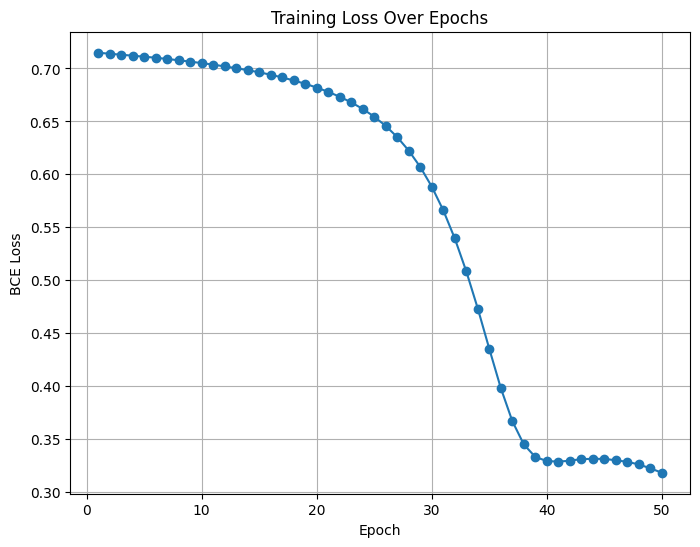

Saved predicted whole mask in 'outputs/predicted_whole_image.png'.
IoU: 0.7739, Precision: 0.7973, Recall: 0.9635


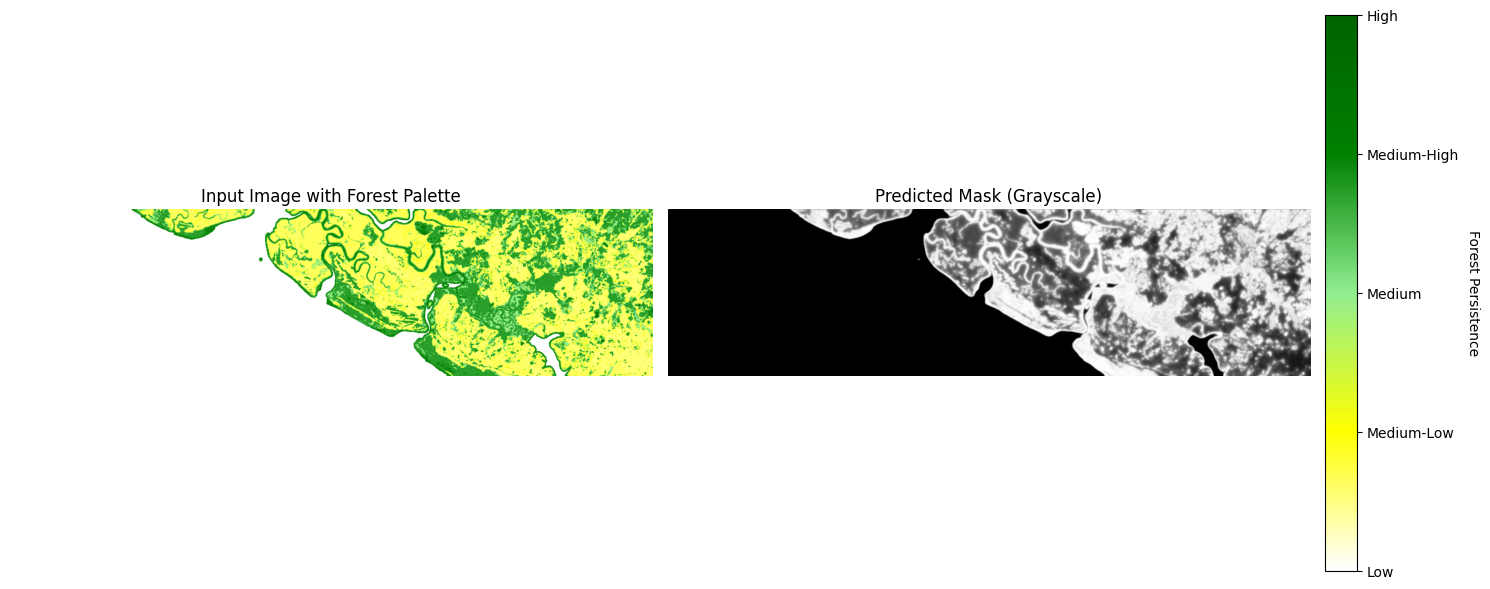

In [ ]:
# ==========================================
# Step 0: Install required libraries
# pip install earthengine-api geemap torch torchvision opencv-python matplotlib Pillow
# ==========================================
from google.colab import drive
drive.mount('/content/drive')
# Step 1: Google Earth Engine setup and export
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='erudite-imprint-458001-e5')

roi = ee.Geometry.BBox(-60.0, -10.0, -59.5, -9.5)
gfc = ee.Image('UMD/hansen/global_forest_change_2020_v1_8')
loss = gfc.select('loss')

task = ee.batch.Export.image.toDrive(
    image=loss.clip(roi),
    description='forest_loss_amazon',
    folder='EarthEngineExports',
    fileNamePrefix='forest_loss_amazon',
    region=roi,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e9
)
task.start()
print("Export started from Earth Engine. Wait for download from Google Drive.")

# ==========================================
# Step 2: Convert .tif to .png
# ==========================================
from PIL import Image
import os

tif_path = "/content/drive/MyDrive/mask/persistent_forest_colored_africa.tif"
image = Image.open(tif_path)

os.makedirs("data/images", exist_ok=True)
os.makedirs("data/masks", exist_ok=True)

image.convert("RGB").save("data/images/forest_persistence_raw.png")
image.convert("L").save("data/masks/forest_persistence_raw.png")

print("Image and mask saved for training.")

# ==========================================
# Step 3: Define U-Net Model
# ==========================================
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        return torch.sigmoid(self.final(dec1))

# ==========================================
# Step 4: Dataset Loader
# ==========================================
from torch.utils.data import Dataset, DataLoader
import cv2

class ForestDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

# ==========================================
# Helper functions: Padding and Cropping
# ==========================================
import torch.nn.functional as F

def pad_to_multiple(x, multiple=32):
    _, _, h, w = x.shape
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    x_padded = F.pad(x, (0, pad_w, 0, pad_h), mode='reflect')
    return x_padded, h, w

def unpad(x, h, w):
    return x[:, :, :h, :w]

# ==========================================
# Step 5: Training Loop
# ==========================================
# ==========================================
# Step 5: Training Loop (Updated with Loss Plot)
# ==========================================
import torch.optim as optim
import matplotlib.pyplot as plt

train_dataset = ForestDataset("data/images", "data/masks")

if len(train_dataset) == 0:
    print("Add image and mask files in 'data/images' and 'data/masks' before training.")
else:
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    model = UNet()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 50  # Change to 50 epochs
    loss_history = []  # <-- Track losses here!

    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0
        for img, mask in train_loader:
            img, orig_h, orig_w = pad_to_multiple(img)
            mask, _, _ = pad_to_multiple(mask)

            pred = model(img)
            loss = criterion(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        avg_loss = loss_sum / len(train_loader)
        loss_history.append(avg_loss)  # <-- Save average loss per epoch
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.6f}")

    # ==========================================
    # After training: Plot the loss curve
    # ==========================================
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.grid(True)
    plt.savefig("outputs/loss_curve.png")  # Save plot
    plt.show()



# ==========================================
# Step 6: Evaluation + Save Whole Image Output
# ==========================================
os.makedirs("outputs", exist_ok=True)
model.eval()

input_path = "data/images/forest_persistence_raw.png"
image = cv2.imread(input_path)

image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0) / 255.0
image_padded, orig_h, orig_w = pad_to_multiple(image_tensor)

with torch.no_grad():
    pred_padded = model(image_padded)

prediction = unpad(pred_padded, orig_h, orig_w)

pred_mask = prediction.squeeze().numpy() * 255
cv2.imwrite("outputs/predicted_whole_image.png", pred_mask.astype('uint8'))

print("Saved predicted whole mask in 'outputs/predicted_whole_image.png'.")
# Step 6 (Fixed Metrics Calculation)

def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    pred_binary = (pred_mask >= threshold).astype(np.uint8)
    true_binary = (true_mask >= threshold).astype(np.uint8)

    intersection = (pred_binary & true_binary).sum()
    union = (pred_binary | true_binary).sum()
    iou = intersection / (union + 1e-6)

    tp = (pred_binary * true_binary).sum()
    fp = (pred_binary * (1 - true_binary)).sum()
    fn = ((1 - pred_binary) * true_binary).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return iou, precision, recall

# Load ground truth mask (normalize to [0,1])
true_mask_path = "data/masks/forest_persistence_raw.png"
true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Load prediction and normalize (IMPORTANT)
pred_mask = cv2.imread("outputs/predicted_whole_image.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Resize if necessary
pred_resized = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

# Calculate metrics
iou, precision, recall = calculate_metrics(pred_resized, true_mask)

print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# ==========================================
# Step 7: Visualization
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colorbar as colorbar

# Load input
img_np = image_tensor.squeeze().permute(1, 2, 0).numpy()
pred_np = prediction.squeeze().numpy()

# -- Prepare custom colormap for Input Image --
colors = [
    (1.0, 1.0, 1.0),    # White
    (1.0, 1.0, 0.0),    # Yellow
    (0.5647, 0.9333, 0.5647),  # Light Green
    (0.0, 0.5, 0.0),    # Green
    (0.0, 0.3922, 0.0)  # Dark Green
]
forest_cmap = LinearSegmentedColormap.from_list("forest_palette", colors, N=256)

# Convert input image to grayscale for applying palette
img_gray = img_np.mean(axis=2)

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# --- Input image (apply forest colormap) ---
im0 = axs[0].imshow(img_gray, cmap=forest_cmap, vmin=0, vmax=1)
axs[0].set_title("Input Image with Forest Palette")
axs[0].axis("off")

# --- Predicted mask (grayscale, no change) ---
axs[1].imshow(pred_np, cmap='gray')
axs[1].set_title("Predicted Mask (Grayscale)")
axs[1].axis("off")

# --- Colorbar ---
cbar = plt.colorbar(im0, cax=axs[2])
cbar.set_label('Forest Persistence', rotation=270, labelpad=15)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

plt.tight_layout()
plt.show()
